## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(env, state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary.
def add_to_dict(env, Q_dict, state):
    state1 = Q_state(state)

    if state1 not in Q_dict.keys():
        valid_act = valid_actions(env, state)
        for action in valid_act:
            Q_dict[state1][action] = 0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(env, Q_dict, state, time, min_epsilon, max_epsilon, decay_rate):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(
        -decay_rate * time)
    z = np.random.random()

    if z > epsilon:
        state_key = Q_state(state)
        action = max(
            Q_dict[state_key], key=Q_dict[state_key].get
        )  # Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = random.choice(list(env.action_space(
            state)[0]))  # Exploration: randomly choosing and action

    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [('x-x-x-x-x-x-x-x-x', (7, 5)),
                  ('x-x-x-x-x-x-x-x-x', (7, 3)),
                  ('x-3-x-x-x-2-x-x-x', (3, 7)),
                  ('5-x-8-x-x-x-x-x-x', (1, 1))]


def initialise_tracking_states(States_track):
    for q_values in tracked_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [7]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [8]:
def save_tracking_states(States_track, Q_dict):
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

### Q_dict and tracking states will be defined and initialized in q_learning method.

In [9]:
#initialise_tracking_states()
# The tracking states 

#### Define hyperparameters  ---write your code here

In [10]:
MAX_EPSILON = 1.0
MIN_EPSILON = 0.001
DECAY_RATE= 0.00001

EPISODES = 5000000
LR = 0.1                  
GAMMA = 0.90

### Q-update loop ---write your code here

In [11]:
def plot_epsilon_decay(episodes, min_epsilon, max_epsilon, decay_rate):
    time = np.arange(0, episodes)
    epsilon = []
    for i in range(0, episodes):
        epsilon.append(min_epsilon +
                       (max_epsilon - min_epsilon) * np.exp(-decay_rate * i))
    plt.title("Epsilon Decay")
    plt.plot(time, epsilon)
    plt.show()

In [12]:
def plot_tracked_values(States_track):
    fig, axs = plt.subplots(1, 4, figsize=(15, 2))
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(States_track[tracked_value[0]][tracked_value[1]])))
        plt.subplot(1, 4, index+1)
        plt.plot(xaxis, np.asarray(
            States_track[tracked_value[0]][tracked_value[1]]))
        plt.title(tracked_value[0] +"_"+ "({},{})".format(tracked_value[1][0],tracked_value[1][1]))
    plt.show()

In [13]:
import pandas as pd


def convert_to_data_frame(data):
    df = pd.DataFrame.from_records(data)
    return df

In [14]:
def plot_model_performance(stats):
    plt.plot(stats['episode'],
         stats['win'],
         label='Win percentange')
    plt.plot(stats['episode'],
             stats['loss'],
             label='Loss percentage')
    plt.plot(stats['episode'],
             stats['tie'],
             label='Tie percentage')

    plt.title("Model performance")
    plt.ylabel('Percentage')
    plt.xlabel('Episodes')
    plt.legend(loc="upper left")

    plt.show()

In [15]:
def q_learning(params, max_epsilon=1.0, episodes=50000, verbose=False):
    lr = params[0]
    gamma = params[1]
    min_epsilon = params[2]
    decay_rate = params[3]
    log_threshold = episodes * .05
    threshold = episodes * .001 #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
    policy_threshold = episodes * 0.05  #every these many episodes, the Q-dict will be updated

    print("learning_rate", lr)
    print("gamma", gamma)
    print("min_epsilon", min_epsilon)
    print("decay_rate", decay_rate)
    print("max_epsilon", max_epsilon)
    print("number of episodes", episodes)
    print("log_threshold", log_threshold)
    print("threshold", threshold)
    print("policy_threshold", policy_threshold)

    Q_dict = collections.defaultdict(dict)
    States_track = collections.defaultdict(dict)
    initialise_tracking_states(States_track)

    start_time = time.time()
    win = 0
    loss = 0
    tie = 0
    data = []
    for episode in range(episodes):
        # Start writing your code from the next line
        env = TicTacToe()

        curr_state = env.state
        is_game_finished = False

        add_to_dict(env, Q_dict, curr_state)

        reward = 0

        while not is_game_finished:
            current_state_key = Q_state(curr_state)

            curr_action = epsilon_greedy(env, Q_dict, curr_state, episode,
                                         min_epsilon, max_epsilon, decay_rate)

            next_state, reward, is_game_finished = env.step(
                curr_state, curr_action)

            next_state_key = Q_state(next_state)

            add_to_dict(env, Q_dict, next_state)

            if is_game_finished:
                # Calculating win, tie and loss count based on the reward.
                if reward == 0:
                    tie += 1
                elif reward == -10:
                    loss += 1
                else:
                    win += 1
                Q_dict[current_state_key][curr_action] += lr * \
                    ((reward) - Q_dict[current_state_key][curr_action])
            else:
                # this gets the action for max q-value of next state
                max_next = max(Q_dict[next_state_key],
                               key=Q_dict[next_state_key].get)
                Q_dict[current_state_key][curr_action] += lr * (
                    (reward + (gamma * (Q_dict[next_state_key][max_next]))) -
                    Q_dict[current_state_key][curr_action])

            curr_state = next_state

        current_episode = episode + 1
        if current_episode % log_threshold == 0:
            row = {}
            row["win"] = round(win / current_episode, 4)
            row["loss"] = round(loss / current_episode, 4)
            row["tie"] = round(tie / current_episode, 4)
            row["episode"] = current_episode
            data.append(row)
            if verbose:
                print("Episode ", current_episode, "Win: ", row["win"], "Loss: ",
                      row["loss"], "Tie: ", row["tie"])

        if (current_episode % threshold) == 0:
            save_tracking_states(States_track, Q_dict)
            save_obj(States_track, 'States_tracked')

        # SAVING POLICY
        if (current_episode % policy_threshold) == 0:
            save_obj(Q_dict, 'Policy')

    elapsed_time = time.time() - start_time
    save_obj(States_track, 'States_tracked')
    save_obj(Q_dict, 'Policy')
    print("elapsed_time", elapsed_time)
    return convert_to_data_frame(data), Q_dict, States_track

In [16]:
params = [LR, GAMMA, MIN_EPSILON, DECAY_RATE]
stats, Q_dict, States_track = q_learning(params=params,
                                         episodes=EPISODES,
                                         verbose=True)

learning_rate 0.1
gamma 0.9
min_epsilon 0.001
decay_rate 1e-05
max_epsilon 1.0
number of episodes 5000000
log_threshold 250000.0
threshold 5000.0
policy_threshold 250000.0
Episode  250000 Win:  0.3498 Loss:  0.2428 Tie:  0.4074
Episode  500000 Win:  0.6043 Loss:  0.1437 Tie:  0.252
Episode  750000 Win:  0.7093 Loss:  0.1021 Tie:  0.1886
Episode  1000000 Win:  0.7631 Loss:  0.0807 Tie:  0.1561
Episode  1250000 Win:  0.7956 Loss:  0.0679 Tie:  0.1366
Episode  1500000 Win:  0.8171 Loss:  0.0593 Tie:  0.1236
Episode  1750000 Win:  0.8325 Loss:  0.0532 Tie:  0.1143
Episode  2000000 Win:  0.8441 Loss:  0.0486 Tie:  0.1073
Episode  2250000 Win:  0.8531 Loss:  0.045 Tie:  0.1018
Episode  2500000 Win:  0.8604 Loss:  0.0422 Tie:  0.0975
Episode  2750000 Win:  0.8664 Loss:  0.0398 Tie:  0.0938
Episode  3000000 Win:  0.8714 Loss:  0.0378 Tie:  0.0908
Episode  3250000 Win:  0.8757 Loss:  0.0362 Tie:  0.0881
Episode  3500000 Win:  0.8792 Loss:  0.0348 Tie:  0.086
Episode  3750000 Win:  0.8823 Loss: 

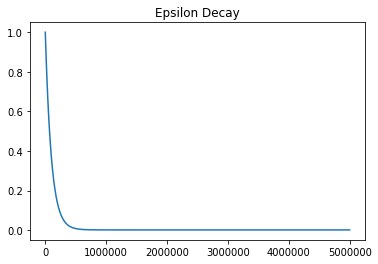

In [17]:
plot_epsilon_decay(episodes=EPISODES,
                   max_epsilon=MAX_EPSILON,
                   min_epsilon=MIN_EPSILON,
                   decay_rate=DECAY_RATE)

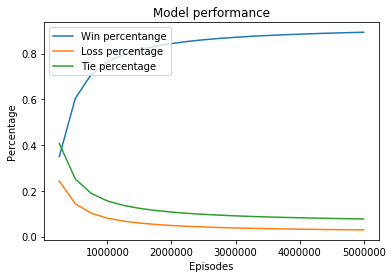

In [18]:
plot_model_performance(stats)

#### Check the Q-dictionary

In [19]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.315373454027195,
              (0, 3): -1.2211149533174521,
              (0, 5): -1.3149536786467475,
              (0, 7): -1.3475460477173353,
              (0, 9): -0.5534431439552382,
              (1, 1): -1.3502331905641887,
              (1, 3): -1.340410228527302,
              (1, 5): 4.991918209535812,
              (1, 7): -1.3619864943286755,
              (1, 9): -1.2773115715477108,
              (2, 1): -1.3518313468228076,
              (2, 3): -1.1391050706446735,
              (2, 5): -1.2569888308925188,
              (2, 7): -1.3512703645048432,
              (2, 9): -0.5809081217195053,
              (3, 1): -1.3532705339834161,
              (3, 3): -1.3663990957380865,
              (3, 5): -1.3748670047820042,
              (3, 7): -1.3590569808257889,
              (3, 9): -1.2328923618080418,
              (4, 1): -1.3607133793758908,
              (4, 3): -1.3691817164833464,
              (4, 5

In [20]:
len(Q_dict)

530360

In [21]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
max(Q_dict['x-x-x-x-x-x-x-x-x'],key=Q_dict['x-x-x-x-x-x-x-x-x'].get)

(1, 5)

#### Check the states tracked for Q-values convergence
(non-evaluative)

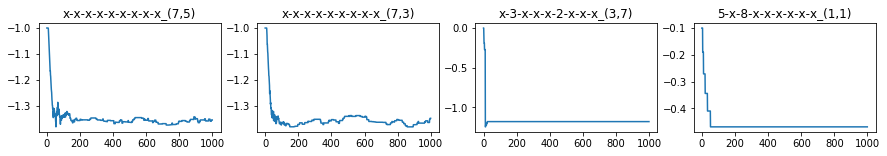

In [22]:
plot_tracked_values(States_track)